# Diabetic Eye Detection model with Transfer Learning using Resnet50

## Importing the libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os, cv2, PIL
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

## Preprocessing the dataset

In [2]:
# The image dataset (INDIAN DIABETIC RETINOPATHY IMAGE DATASET (IDRID)) was available in https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid#files  

# Generate training set and test set
data_dir='DS_IDRID/'

In [3]:
# Specifi image and batch size
batch_size = 32
image_size = (227,227)

In [4]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=100,
  validation_split=0.3,
  subset="training",
  image_size=image_size,
  batch_size=batch_size)

Found 516 files belonging to 2 classes.
Using 362 files for training.


In [5]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=100,
  validation_split=0.3,
  subset="validation",
  image_size=image_size,
  batch_size=batch_size)

Found 516 files belonging to 2 classes.
Using 154 files for validation.


In [6]:
class_names = np.array(train_ds.class_names)
num_classes = len(class_names)
print(class_names)

['0' '1']


There are two classes. '0' represents eyes without diabetic disease. '1' represents eyes with diabetic diseases at different levels.

# Check Images

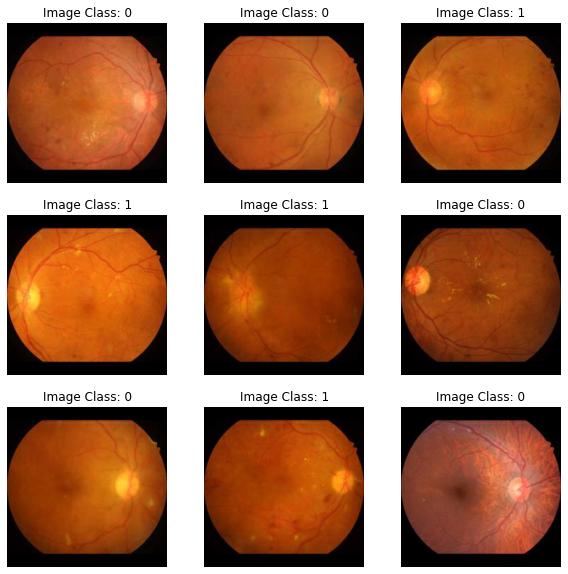

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title('Image Class: ' + str(class_names[labels[i]]))
    plt.axis("off")

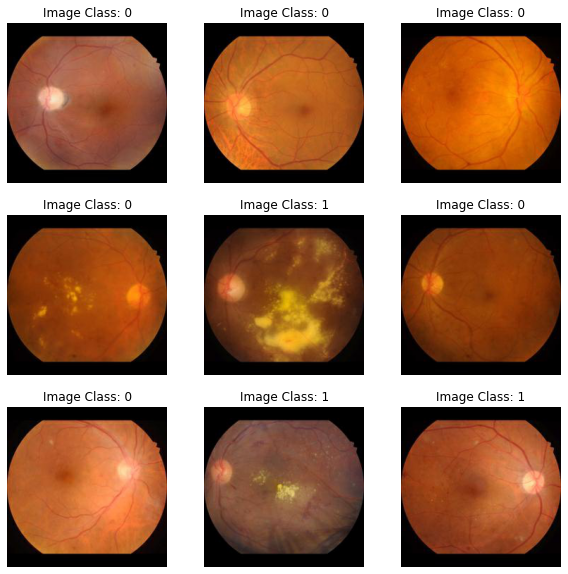

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title('Image Class: ' + str(class_names[labels[i]]))
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


## Performance adjustment

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Apply data augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
])

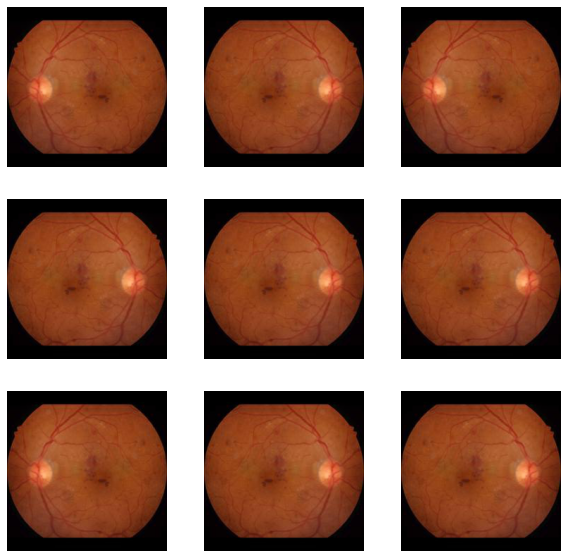

In [12]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescaling the pixel values of the images

In [13]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Create the base model from a pre-trained model

In [14]:

IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
# Feature extractor output
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


## Freezing the base model - Excluding from training

In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 114, 114, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Add a classification head

In [18]:
#tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [19]:
# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [20]:
#Build a model by chaining together the data augmentation, rescaling, base_model and 
#feature extractor layers using the Keras Functional API. As previously mentioned, 
#use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
len(model.trainable_variables)

2

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 227, 227, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 227, 227, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 227, 227, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [24]:
## Train the model
initial_epochs = 10
# Initial accuracy and loss check
loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 19s 4s/step - loss: 0.5763 - accuracy: 0.7658


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.57
initial accuracy: 0.77


In [26]:
# Model training
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
12/12 [==============================] - 59s 5s/step - loss: 0.6965 - accuracy: 0.6685 - val_loss: 0.5290 - val_accuracy: 0.7597
Epoch 2/10
12/12 [==============================] - 51s 4s/step - loss: 0.6537 - accuracy: 0.6409 - val_loss: 0.5329 - val_accuracy: 0.7792
Epoch 3/10
12/12 [==============================] - 48s 4s/step - loss: 0.5806 - accuracy: 0.6851 - val_loss: 0.5052 - val_accuracy: 0.7792
Epoch 4/10
12/12 [==============================] - 52s 4s/step - loss: 0.5786 - accuracy: 0.6934 - val_loss: 0.4853 - val_accuracy: 0.7857
Epoch 5/10
12/12 [==============================] - 47s 4s/step - loss: 0.5272 - accuracy: 0.7155 - val_loss: 0.4827 - val_accuracy: 0.7922
Epoch 6/10
12/12 [==============================] - 47s 4s/step - loss: 0.5247 - accuracy: 0.7210 - val_loss: 0.4786 - val_accuracy: 0.7857
Epoch 7/10
12/12 [==============================] - 51s 4s/step - loss: 0.5529 - accuracy: 0.7127 - val_loss: 0.4649 - val_accuracy: 0.7987
Epoch 8/10
12/12 [==

## Learning curves

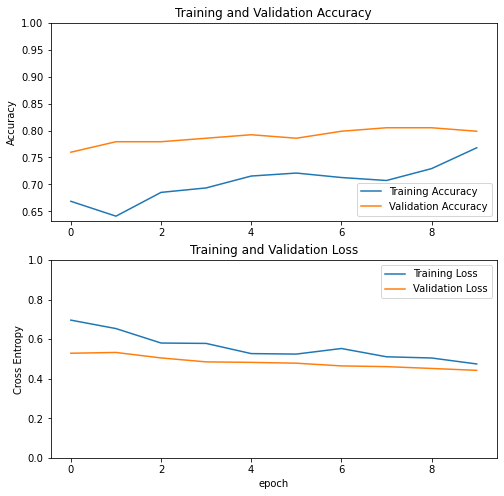

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(num= 1, figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The base model layers were fron to make them untrainable. The model accuracy improved slightly after 3 epochs.

# Fine Tuning - Training top layers of the pre-trained model

In [28]:
# Unfreezing some of the layers of the pre-trained model

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


# Recompile the model

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 227, 227, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 227, 227, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 227, 227, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [31]:
len(model.trainable_variables)

92

In [32]:
# Continue training the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
12/12 [==============================] - 87s 7s/step - loss: 0.5997 - accuracy: 0.7087 - val_loss: 0.5785 - val_accuracy: 0.6818
Epoch 11/20
12/12 [==============================] - 82s 7s/step - loss: 0.5033 - accuracy: 0.7313 - val_loss: 0.4456 - val_accuracy: 0.7727
Epoch 12/20
12/12 [==============================] - 82s 7s/step - loss: 0.4134 - accuracy: 0.8079 - val_loss: 0.4770 - val_accuracy: 0.7532
Epoch 13/20
12/12 [==============================] - 83s 7s/step - loss: 0.4438 - accuracy: 0.7618 - val_loss: 0.4351 - val_accuracy: 0.7857
Epoch 14/20
12/12 [==============================] - 84s 7s/step - loss: 0.3774 - accuracy: 0.8115 - val_loss: 0.5034 - val_accuracy: 0.7468
Epoch 15/20
12/12 [==============================] - 86s 7s/step - loss: 0.3120 - accuracy: 0.8589 - val_loss: 0.4519 - val_accuracy: 0.8052
Epoch 16/20
12/12 [==============================] - 105s 9s/step - loss: 0.3114 - accuracy: 0.8796 - val_loss: 0.3354 - val_accuracy: 0.8247
Epoch 17/20


In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

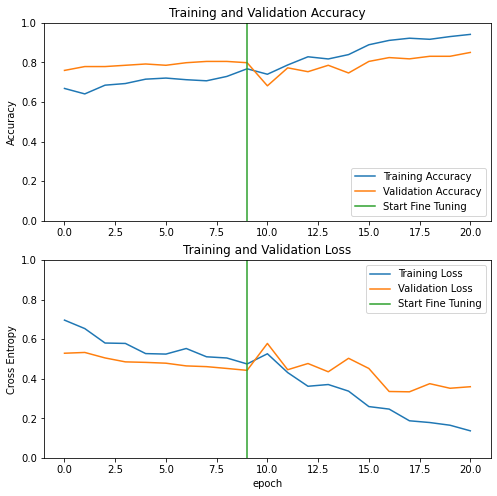

In [34]:
plt.figure(num=2, figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.00, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.show()

After making some layers trainable in the base model, the accuracy improved significantly.

In [35]:
image_batch, label_batch = next(iter(val_ds))
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

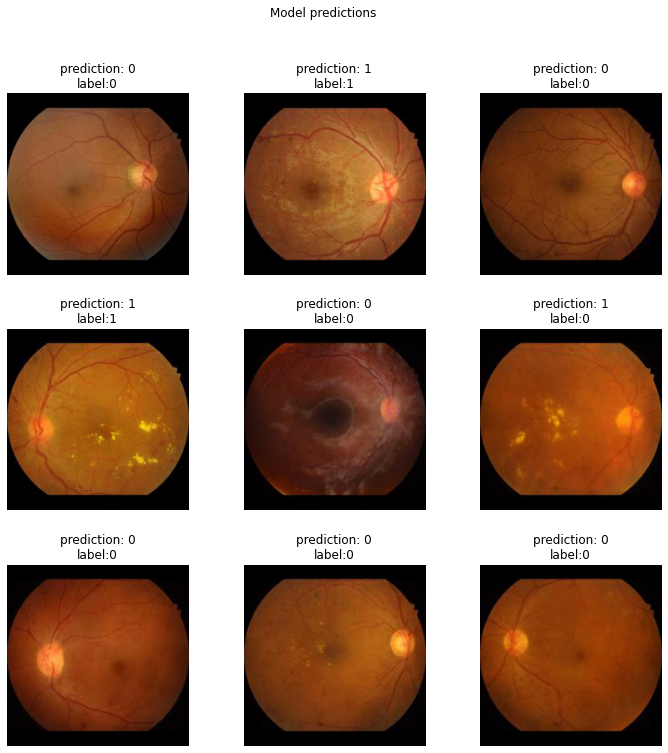

In [36]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(image_batch[n].numpy().astype("uint8"))
  ptitle =  ("prediction: {0}\nlabel:{1}". \
             format(predicted_label_batch[n].title() \
                    , str(tf.keras.backend.get_value(label_batch[n])) ) ) 
  plt.title(ptitle)
  plt.axis('off')
_ = plt.suptitle("Model predictions")